CSS - Final Project

In [138]:
import json, re, glob
import pandas as pd
import networkx as nx
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import re
import glob, json, os
from tqdm import tqdm

In [143]:
data_dir = "../congresstweets/data"

print("Looking in:", data_dir)
print("Contents:", os.listdir(data_dir)[:5])

json_paths = glob.glob(os.path.join(data_dir, "*.json"))
print(f"Found {len(json_paths)} JSON files")

tweets = []
for path in tqdm(json_paths):
    with open(path, "r", encoding="utf-8") as f:
        tweets.extend(json.load(f))

df = pd.DataFrame(tweets)
print(f"Loaded {len(df)} tweets")
df.head()


Looking in: ../congresstweets/data


FileNotFoundError: [Errno 2] No such file or directory: '../congresstweets/data'

In [ ]:
def get_contexts(word, texts, width=40):
        wc = int(width/4)                # words of context
        for i in :
            lcontext = ' '.join(self._text[i-wc:i])
            rcontext = ' '.join(self._text[i:i+wc])
            ldisplay = '{:>{width}}'.format(lcontext[-width:], width=width)
            rdisplay = '{:{width}}'.format(rcontext[:width], width=width)
            print(ldisplay, rdisplay)

In [60]:
import nltk
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize
def mention_context_sentiment(text, handle, window_size=10):
    """
    Given the full tweet text and one handle (without @),
    find all occurrences of '@handle' in the token list,
    build a ±window_size word context around each,
    compute each context's VADER compound score,
    and return the average (or 0.0 if no mention found).
    """
    tokens = word_tokenize(text)
    mention_token = '@' + handle.lower()
    
    # normalize tokens for matching
    lowered = [t.lower() for t in tokens]
    
    scores = []
    for i, tok in enumerate(lowered):
        if tok == mention_token:
            start = max(0, i - window_size)
            end   = min(len(tokens), i + window_size + 1)
            ctx = tokens[start:end]
            ctx_text = ' '.join(ctx)
            scores.append(analyzer.polarity_scores(ctx_text)['compound'])
    
    return sum(scores) / len(scores) if scores else 0.0

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Magnus/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Magnus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [91]:
def mention_context_sentiment(text, handle, window_size=10):
    """
    For each @handle in `text`, pull out up to `window_size` words
    before and after, run VADER on that slice, and average.
    """
    # 1) clean the handle
    handle_clean = handle.lower().lstrip('@')
    # 2) compile a regex that grabs up to window_size words on each side
    #    \S+ matches a "word" (non-space)
    pattern = re.compile(
        rf'(?:\S+\s+){{0,{window_size}}}@{re.escape(handle_clean)}(?:\s+\S+){{0,{window_size}}}',
        flags=re.IGNORECASE
    )
    scores = []
    for m in pattern.finditer(text):
        ctx = m.group(0)
        scores.append(analyzer.polarity_scores(ctx)['compound'])
    return sum(scores) / len(scores) if scores else 0.0

In [93]:
SAMPLE_SIZE = 300_000
df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42).reset_index(drop=True)
print(f"Working on {len(df_sample):,} tweets (out of {len(df):,})")

mention_re = re.compile(r"@([A-Za-z0-9_]+)")

G = nx.DiGraph()
for screen_name, text in tqdm(zip(df_sample["screen_name"], df_sample["text"]), desc="Tweets processed", total = 300_000):
    mentions = set(m.lower() for m in mention_re.findall(text))
    src = screen_name.lower()
    for tgt in mentions:
        mention_sentiment = mention_context_sentiment(text, tgt)
        if tgt == src:
            continue
        if G.has_edge(src, tgt):
            G[src][tgt]["n_mentions"] += 1
            G[src][tgt]["avg_sentiment"] += mention_sentiment
        else:
            G.add_edge(src, tgt, n_mentions=1, avg_sentiment = mention_sentiment)
for src, tgt in tqdm(G.edges(), desc='Averaging sentiments'): # Average sentiment values
    G[src][tgt]['avg_sentiment'] = G[src][tgt]['avg_sentiment']/G[src][tgt]['n_mentions']
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
in_degs  = np.array([d for _, d in G.in_degree()])
out_degs = np.array([d for _, d in G.out_degree()])

print(f"Nodes: {num_nodes:,}")
print(f"Edges: {num_edges:,}")
print(f"In‑degree → mean: {in_degs.mean():.2f},  std: {in_degs.std():.2f}")
print(f"Out‑degree → mean: {out_degs.mean():.2f}, std: {out_degs.std():.2f}")

low_weight = [(u, v) for u, v, d in G.edges(data=True) if d["n_mentions"] < 3]
G.remove_edges_from(low_weight)
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

print(f"After pruning: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
in_degs  = np.array([d for _, d in G.in_degree()])
out_degs = np.array([d for _, d in G.out_degree()])
print(f"In‑degree → mean: {in_degs.mean():.2f},  std: {in_degs.std():.2f}")
print(f"Out‑degree → mean: {out_degs.mean():.2f}, std: {out_degs.std():.2f}")


Working on 300,000 tweets (out of 5,068,352)


Averaging sentiments: 100%|██████████| 177616/177616 [00:00<00:00, 746580.65it/s]


Nodes: 56,924
Edges: 177,616
In‑degree → mean: 3.12,  std: 12.68
Out‑degree → mean: 3.12, std: 31.54
After pruning: 5,358 nodes, 17,713 edges
In‑degree → mean: 3.31,  std: 13.49
Out‑degree → mean: 3.31, std: 13.35


In [ ]:
import pandas as pd
#from ace_tools import display_dataframe_to_user

# Extract (source, target, avg_sentiment) for all edges
edge_data = [(u, v, data.get('avg_sentiment', 0.0)) for u, v, data in G.edges(data=True)]
sent_df = pd.DataFrame(edge_data, columns=['source', 'target', 'avg_sentiment'])

# Sort to get extremes
sent_df_sorted = sent_df.sort_values('avg_sentiment')
neg_df = sent_df_sorted.head(5).reset_index(drop=True)
pos_df = sent_df_sorted.tail(5).sort_values('avg_sentiment', ascending=False).reset_index(drop=True)

# Display the tables to the user
print('5 Most Negative Sentiment Edges\n', neg_df)
print('\n5 Most Positive Sentiment Edges\n', pos_df)

5 Most Negative Sentiment Edges
            source           target  avg_sentiment
0     lacyclaymo1  socialpowerone1      -0.803100
1    nmalliotakis          bpunion      -0.748433
2  repandybiggsaz       bucksexton      -0.719500
3     appropsdems      replawrence      -0.698100
4    reppaultonko           cdcgov      -0.649100
5 Most Positive Sentiment Edges
            source           target  avg_sentiment
0   chrismurphyct       rexchapman       0.931233
1  repcarolmiller  woodywilliams45       0.917100
2       teamamash      steffi_cole       0.899000
3     timburchett  langford_stacey       0.867767
4       dinatitus    goldenknights       0.861550


In [94]:
sent_series = df_sample["text"].apply(analyzer.polarity_scores).apply(pd.Series)
df_sample = pd.concat([df_sample, sent_series], axis=1)


user_stats = (
    df_sample
    .groupby("screen_name")["compound"]
    .agg(["mean","median","std","count"])
    .reset_index()
)

user_stats.columns = [
    "screen_name",
    "avg_compound",
    "med_compound",
    "std_compound",
    "n_tweets"
]

print("Sample of per‐user sentiment stats:")
print(user_stats.head())


mapping_avg   = dict(zip(user_stats["screen_name"].str.lower(), user_stats["avg_compound"]))
mapping_count = dict(zip(user_stats["screen_name"].str.lower(), user_stats["n_tweets"]))

nx.set_node_attributes(G, mapping_avg,   "avg_sentiment_account")
nx.set_node_attributes(G, mapping_count, "n_tweets")


top5 = user_stats.nlargest(5, "avg_compound")[["screen_name","avg_compound","n_tweets"]]
bot5 = user_stats.nsmallest(5, "avg_compound")[["screen_name","avg_compound","n_tweets"]]
print("\nTop 5 happiest accounts:\n", top5.to_string(index=False))
print("\nTop 5 saddest accounts:\n", bot5.to_string(index=False))


Sample of per‐user sentiment stats:
    screen_name  avg_compound  med_compound  std_compound  n_tweets
0   ABrindisiNY      0.375948        0.5399      0.515374        25
1  ANTHONYDESPO      0.305815        0.6352      0.681033        59
2           AOC      0.229071        0.4019      0.595130       514
3   ASEANCaucus      0.487633        0.6158      0.462115         6
4    AaronPBean      0.658950        0.8468      0.443547         4

Top 5 happiest accounts:
     screen_name  avg_compound  n_tweets
     JenKiggans      0.962100         1
      johnthune      0.960600         1
MarchantforTX24      0.948500         1
  YadiraCaraveo      0.942600         2
 VanHollenForMD      0.934667         3

Top 5 saddest accounts:
    screen_name  avg_compound  n_tweets
 DeliaCRamirez       -0.7096         1
  RatcliffeTX4       -0.7003         1
 Votejimjordan       -0.4767         1
  VoteLouiseNY       -0.4588         1
AndreaRSalinas       -0.4404         1


In [95]:
color_map = {
    'negative': '#d62728',   # red
    'neutral':  '#7f7f7f',   # gray
    'positive': '#2ca02c'    # green
}
for k, v in G.nodes(data=True):
    if v:
        avg_sentiment = v['avg_sentiment_account']
    else: avg_sentiment = 0
    v['group'] = color_map['positive'] if avg_sentiment > 0.1 else color_map['negative'] if avg_sentiment < -0.1 else color_map['neutral']

In [96]:
def get_deg_assortativity_coef(G):
    degrees = dict(G.degree())
    N = len(G.edges())

    same_deg = 0
    for (i, j) in list(G.edges()): # Compute total amount of edges between nodes of equal degree
        if degrees[i] == degrees[j]:
            same_deg += 1/N

    degs = np.array(list(degrees.values()))
    exp_same_deg = 0
    total_half_stubs = sum(degs)
    for deg in set(degs): # Compute expected number of edges between nodes of same degree 
        n_deg = len(degs[degs == deg])
        n_half_stubs = n_deg*deg
        exp_same_deg += (n_half_stubs/total_half_stubs)**2

    r = (same_deg - exp_same_deg)/(1-exp_same_deg)
    return r

In [97]:
get_deg_assortativity_coef(G)

-0.01012482441275055

In [125]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import netwulf

network_properties, config = netwulf.visualize(G, plot_in_cell_below=False)
print('got data')

for link in network_properties['links']:
    src = link['source']   
    tgt = link['target'] 
    # Add avg sentiment back to link
    link['avg_sentiment'] = G[src][tgt]['avg_sentiment']

sents = [d['avg_sentiment'] for _,_,d in G.edges(data=True)]
cmap = cm.get_cmap('RdYlGn')
norm = mcolors.Normalize(vmin=min(sents), vmax=max(sents))

for link in network_properties['links']:
    s = link.get('avg_sentiment')
    rgba = cmap(norm(s))
    link['color'] = mcolors.to_hex(rgba)

# now instruct Netwulf to use your manual hexes
config['link_color_field'] = 'color'
# graph_data, config = netwulf.visualize(network_properties, config = config)

/opt/homebrew/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(
Python(40247) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


got data


/var/folders/pw/mnpmywp944s16f9v7t3n65tm0000gp/T/ipykernel_49850/1779668827.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


/var/folders/pw/mnpmywp944s16f9v7t3n65tm0000gp/T/ipykernel_49850/2398427609.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


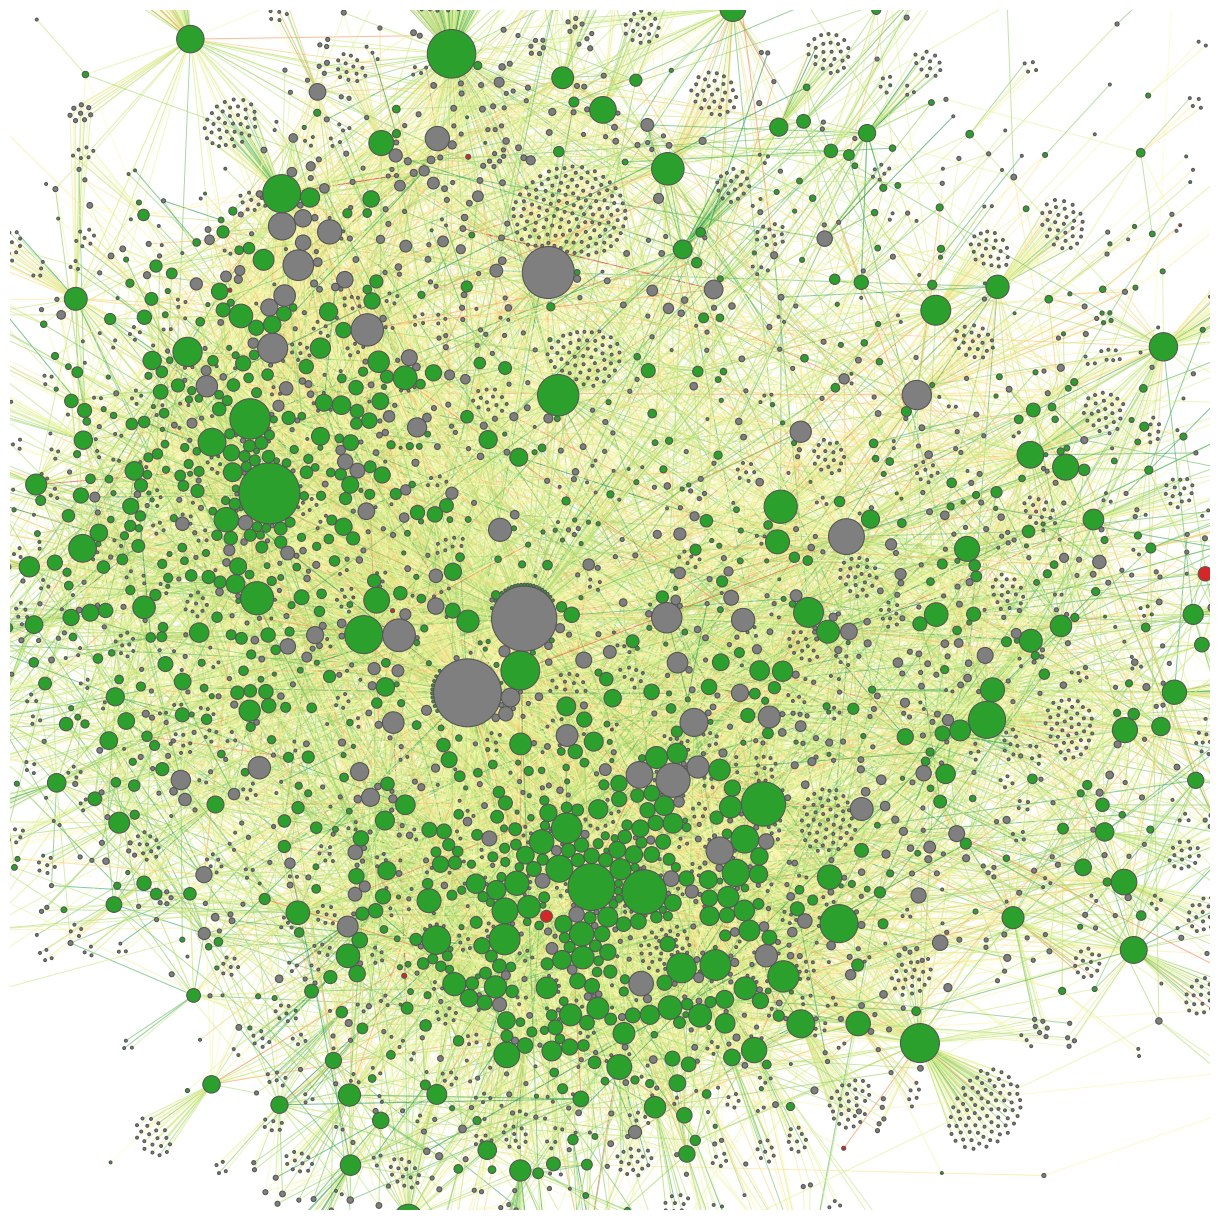

In [126]:
from netwulf.tools import draw_netwulf

# 5) Draw statically via Matplotlib
fig, ax = draw_netwulf(network_properties, figsize=12)
fig.show()